In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bp
%matplotlib inline

In [122]:
#Se lee la señal anteriormente procesada
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_10T_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)

In [123]:
data_set[:10]

,bid,ask
2018-01-02 00:00:00,1.20015,1.20110
2018-01-02 00:10:00,1.20082,1.20126
2018-01-02 00:20:00,1.20049,1.20085
2018-01-02 00:30:00,1.20079,1.20113
2018-01-02 00:40:00,1.20143,1.20158
2018-01-02 00:50:00,1.20133,1.20156
2018-01-02 01:00:00,1.20058,1.20068
2018-01-02 01:10:00,1.20087,1.20096
2018-01-02 01:20:00,1.20134,1.20140
2018-01-02 01:30:00,1.20144,1.20150


In [124]:
# %load ../code/build_dataset.py
def build_dataset(df, window, binary_target=False, delete_constant_values=True, PNL=False):
    """
    función para construir un data set
    window: tamaño de la ventana a utilizar para construir el dataset
    df: dataframe, con columna bid y ask.
    binary_target: si desea clasificar, este arroja 2 si el valor se mantiene,
    1 si el valor sube y 0 si este baja.
    delete_constant_values: default: True, elimina los valores que se mantienen
    
    retorna:
    X: dataset, con columna de PNL si así se especifica(default: False)
    y: target
    bt: binary target, default: False
    """

    import pandas as pd
    import numpy as np
    result = []
    binary = [] #para la columna objetivo binaria
    pnl_buy = [] #almacenar el pnl en caso de compra
    pnl_sell = [] #almacenar el pnl en caso de venta
    signal = df.bid
    ask = df.ask
    indx = signal.index[window-1:-1] #se toman los indicen que quedarán al final
    for i in range(len(signal)-window):
        
        if delete_constant_values == True:
            if signal[i+window] != signal[i+window-1]:

                result.append(signal[i: i + window+1])
                if PNL == True: 
                    pnl_sell.append(signal[i+window-1] - ask[i+window]) #calcular pnl en caso de venta-compra
                    pnl_buy.append(signal[i+window] - ask[i+window-1]) #calcular pnl en caso de compra-venta
                
                if binary_target == True:
                    if signal[i+window] < signal[i+window-1]: 
                        if (signal[i+window-1] - ask[i+window]) > 0: binary.append(0) # 0 si baja y gano
                        else: binary.append(2) # 2 si baja pero pierdo
                            
                    if signal[i+window] > signal[i+window-1]: # 1 si sube
                        if (signal[i+window] - ask[i+window-1]) > 0: binary.append(1) # 1 si sube y gano
                        else: binary.append(3) # 3 si sube pero pierdo
                        
            else: indx = indx.delete(len(result))
                
        else:

            result.append(signal[i: i + window+1])
            if PNL == True:
                pnl_sell.append(signal[i+window-1] - ask[i+window]) #calcular pnl en caso de venta-compra
                pnl_buy.append(signal[i+window] - ask[i+window-1]) #calcular pnl en caso de compra-venta
            
        if binary_target == True and delete_constant_values == False:
            if signal[i+window] == signal[i+window-1]: binary.append(4) # 2 si se mantiene
                
            if signal[i+window] < signal[i+window-1]:
                if (signal[i+window-1] - ask[i+window]) > 0: binary.append(0) # 0 si baja y gano
                else: binary.append(2) # 2 si baja pero pierdo
                    
            if signal[i+window] > signal[i+window-1]:
                if (signal[i+window] - ask[i+window-1]) > 0: binary.append(1) # 1 si sube y gano
                else: binary.append(3) # 3 si sube pero pierdo
    
    data = pd.DataFrame(np.array(result), index=indx)
    y = np.array(data.iloc[:,window])
    data = data.drop(window,axis=1)
    if PNL == True:
        data['PNL_0'] = pnl_sell
        data['PNL_1'] = pnl_buy 
    if binary_target == True: return data, y, np.array(binary)
    else: return data, y

In [154]:
# %load ../code/PNLEstimatorWrapper.py
import pandas as pd
import numpy as np
class PNLEstimatorWrapper:
    
    def __init__(self, estimator, PNL_column, exclude_PNL_column_from_training=True):
        self.estimator = estimator
        self.PNL_column = PNL_column
        self.exclude_PNL_column_from_training = exclude_PNL_column_from_training
        
    def fit(self, X, y):
        assert 'PNL_1' and 'PNL_0' in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column[0] and col!=self.PNL_column[1]]]
        self.estimator.fit(X,y)
        
    def predict(self, X):
        assert 'PNL_1' and 'PNL_0' in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column[0] and col!=self.PNL_column[1]]]
        return self.estimator.predict(X)
    
    def score(self, X, y):
        pnl_1 = X.PNL_1
        pnl_0 = X.PNL_0
        pre = self.predict(X)
        r = sum((pre==1)*pnl_1 + (pre==0)*pnl_0)
        sell = sum(pre==0) + sum(pre==2)
        buy = sum(pre==1) + sum(pre==3)
        percent = np.mean(y==pre)*100
        
        count_ones, count_zeros = 0,0
        l_one, l_zero = [],[]
        for i in pre:
            if i==1:
                l_zero.append(count_zeros)
                count_zeros = 0
                count_ones += 1
            else:
                l_one.append(count_ones)
                count_zeros += 1
                count_ones = 0
        l_zero.append(count_zeros)
        l_one.append(count_ones)
        
        #return np.array([r,buy,sell,max(l_one),max(l_zero)])
        return np.array([r,buy,sell,max(l_one),max(l_zero),percent]), pre
        
    def get_params(self, deep=False):
        return {"PNL_column": self.PNL_column,
                "exclude_PNL_column_from_training": self.exclude_PNL_column_from_training,
                "estimator": self.estimator}

In [155]:
X, y_reg, bt = build_dataset(data_set,window=7,binary_target=True,PNL=True)
X.shape

(3141, 9)

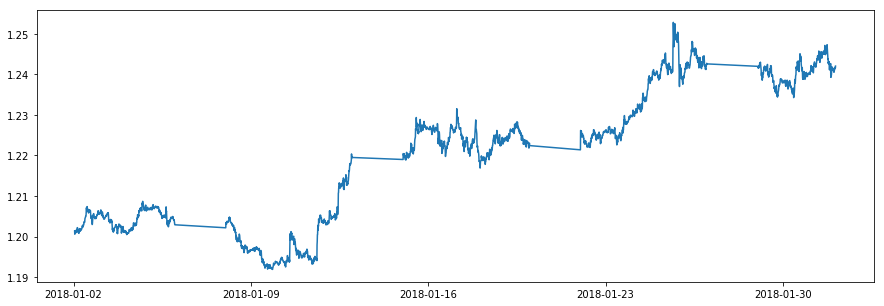

In [156]:
plt.figure(figsize=(15,5))
plt.plot(X.index,X.iloc[:,5]);

In [157]:
data_set.index[2], data_set.index[-1]

(Timestamp('2018-01-02 00:20:00'), Timestamp('2018-02-01 02:00:00'))

In [158]:
X.index[0], X.index[-1]

(Timestamp('2018-01-02 01:00:00'), Timestamp('2018-02-01 01:50:00'))

In [159]:
bt.shape, X.shape

((3141,), (3141, 9))

In [160]:
X.head()

,0,1,2,3,4,5,6,PNL_0,PNL_1
2018-01-02 01:00:00,1.20015,1.20082,1.20049,1.20079,1.20143,1.20133,1.20058,-0.00038,0.00019
2018-01-02 01:10:00,1.20082,1.20049,1.20079,1.20143,1.20133,1.20058,1.20087,-0.00053,0.00038
2018-01-02 01:20:00,1.20049,1.20079,1.20143,1.20133,1.20058,1.20087,1.20134,-0.00016,0.00004
2018-01-02 01:30:00,1.20079,1.20143,1.20133,1.20058,1.20087,1.20134,1.20144,0.00031,-0.00041
2018-01-02 01:40:00,1.20143,1.20133,1.20058,1.20087,1.20134,1.20144,1.20109,0.00006,-0.00015


In [163]:
print('tamaño de los datos= ',X.shape)
print()
print('# veces que baja lo suficiente para ganar = ',sum(bt==0),' | ', np.mean(bt==0),'%')
print('# veces que baja pero pierdo = ',sum(bt==2),' | ', np.mean(bt==2),'%')
print('--------------------------------------------')
print('# veces que sube lo suficiente para ganar = ',sum(bt==1),' | ', np.mean(bt==1),'%')
print('# veces que sube pero pierdo = ',sum(bt==3),' | ', np.mean(bt==3),'%')
print('--------------------------------------------')
print('probabilidad de ganar = ', (np.mean(bt==0)+np.mean(bt==1))*100)
print('probabilidad de perder = ', (np.mean(bt==2)+np.mean(bt==3))*100)

tamaño de los datos=  (3141, 9)

# veces que baja lo suficiente para ganar =  1410  |  0.448901623687 %
# veces que baja pero pierdo =  142  |  0.0452085323145 %
--------------------------------------------
# veces que sube lo suficiente para ganar =  1444  |  0.459726201847 %
# veces que sube pero pierdo =  145  |  0.0461636421522 %
--------------------------------------------
probabilidad de ganar =  90.8627825533
probabilidad de perder =  9.13721744667


In [164]:
sum(X.PNL_0>0), sum(X.PNL_1>0)

(1410, 1444)

In [165]:
%run ../code/redim.py
%run ../code/step_validation.py
%run ../code/v_split.py

In [166]:
from sklearn.naive_bayes import GaussianNB
    
y = bt
n_bdtrain = 4
n_bdtest = 1
mday = 1
#para indexar el dataframe por las fechas
dates = np.unique(X.index.date)[n_bdtrain:]
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_0','PNL_1'])
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('average %correct: ', np.mean(result_GNB[:,5]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells','%correct'])
                      ,index=dates)
print(df_GNB)

--------- GaussianNB ----------------
average PNL :  -0.000865217391305
average buy:  60.5217391304
average sell:  51.7391304348
average %correct:  37.463453536
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells    %correct
2018-01-06 -0.00032    1.0    0.0           1.0            0.0    0.000000
2018-01-08 -0.00337   53.0   88.0          32.0           83.0   20.567376
2018-01-09 -0.00755  141.0    0.0         141.0            0.0   41.134752
2018-01-10  0.00116  118.0   23.0          79.0           23.0   37.588652
2018-01-11  0.00002   80.0   64.0          53.0           55.0   45.833333
2018-01-12  0.00989  141.0    0.0         141.0            0.0   54.609929
2018-01-13 -0.00094    1.0    0.0           1.0            0.0    0.000000
2018-01-15  0.00161   64.0   79.0          48.0           77.0   28.671329
2018-01-16 -0.00016   52.0   92.0          52.0           68.0   25.000000
2018-01-17  0.00125   12.0  131.0          10.0    

In [167]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_0','PNL_1'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('-------- KNeighborsClassifier 5m -------')
print('average PNL: ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('average %correct: ', np.mean(result_KNC[:,5]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells','%correct'])
                      ,index=dates)
print(df_KNC)

-------- KNeighborsClassifier 5m -------
average PNL:  -0.0040447826087
average buy:  53.7391304348
average sell:  58.5217391304
average %correct:  41.3970230066
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells    %correct
2018-01-06 -0.00032    1.0    0.0           1.0            0.0    0.000000
2018-01-08 -0.00478   36.0  105.0           9.0           57.0   26.950355
2018-01-09 -0.00769  122.0   19.0          99.0           13.0   39.716312
2018-01-10 -0.00796   67.0   74.0          17.0           13.0   46.099291
2018-01-11 -0.01531   17.0  127.0           3.0           51.0   42.361111
2018-01-12 -0.01428   68.0   73.0          22.0            8.0   41.843972
2018-01-13 -0.00094    1.0    0.0           1.0            0.0    0.000000
2018-01-15 -0.01050    2.0  141.0           2.0          126.0   42.657343
2018-01-16  0.00483   86.0   58.0          29.0           10.0   46.527778
2018-01-17 -0.00458   81.0   62.0          16.0   

In [168]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('------ DecisionTreeClassifier 5m -------')
print('average PNL: ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('average %correct: ', np.mean(result_DTC[:,5]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells','%correct'])
                      ,index=dates)
print(df_DTC)

------ DecisionTreeClassifier 5m -------
average PNL:  -0.0018347826087
average buy:  60.9130434783
average sell:  51.347826087
average %correct:  38.0228918049
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells    %correct
2018-01-06 -0.00032    1.0    0.0           1.0            0.0    0.000000
2018-01-08 -0.00608   40.0  101.0           9.0           82.0   17.021277
2018-01-09 -0.00433   38.0  103.0          16.0           81.0   41.134752
2018-01-10 -0.00840   89.0   52.0          14.0           11.0   36.879433
2018-01-11 -0.01111   54.0   90.0           4.0           13.0   40.972222
2018-01-12  0.01053  117.0   24.0          86.0            4.0   53.191489
2018-01-13  0.00000    0.0    1.0           0.0            1.0    0.000000
2018-01-15  0.00000  143.0    0.0           0.0          143.0    3.496503
2018-01-16  0.00044  103.0   41.0          14.0            8.0   45.833333
2018-01-17 -0.00594   63.0   80.0           5.0    

In [169]:
from  sklearn.ensemble  import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_1','PNL_0'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('------- RandomForestClassifier 5m -------')
print('PNL promedio: ', np.mean(result_RFC[:,0]))
print('buy promedio: ', np.mean(result_RFC[:,1]))
print('sell promedio: ', np.mean(result_RFC[:,2]))
print('average %correct: ', np.mean(result_RFC[:,5]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells','correct'])
                      ,index=dates)
print(df_RFC)

------- RandomForestClassifier 5m -------
PNL promedio:  -0.00228347826087
buy promedio:  52.0434782609
sell promedio:  60.2173913043
average %correct:  42.4974791082
-------------------------------------
                PNL   buys  sells  longest_buys  longest_sells     correct
2018-01-06 -0.00032    1.0    0.0           1.0            0.0    0.000000
2018-01-08 -0.00331   37.0  104.0           9.0           82.0   21.985816
2018-01-09 -0.00161   38.0  103.0          15.0           79.0   41.843972
2018-01-10 -0.00994   40.0  101.0           8.0           25.0   51.063830
2018-01-11 -0.00720   27.0  117.0           4.0           19.0   44.444444
2018-01-12  0.01001  121.0   20.0          86.0            6.0   55.319149
2018-01-13  0.00000    0.0    1.0           0.0            1.0    0.000000
2018-01-15 -0.00749   21.0  122.0           0.0          143.0   37.062937
2018-01-16 -0.00390  105.0   39.0          28.0            4.0   43.750000
2018-01-17 -0.00938   75.0   68.0          10

In [170]:
X[:'2018-01-05'].shape


(559, 9)

In [171]:
bt.shape, predict_RFC.shape

((3141,), (2582,))